Set working directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

# Change file_path as necessary
file_path = "../" 

os.chdir(file_path)

Load files

In [2]:
def identify_type_of_day(date):
    weekno = date.weekday()
    if((date.month == 7 and week_of_month(date) < 4 ) or (date.month == 12 or date.month == 1 or date.month == 2)):
        return 'Major_study_break'
    elif weekno>5:
        return 'Weekend'
    elif is_public_holiday(date):
        return 'Public_holiday'
    else:
        return 'Study_period_day'

#Week of month
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#Returns True if it's  public holiday
def is_public_holiday(dt):
    #public_holiday file for year 2017, use API/ file having multiple year's records to apply for different years
    public_holidays =  pd.read_csv('australianpublicholidays.csv', sep=',', encoding='ISO-8859-1', parse_dates=['Date'],
                 date_parser=lambda x: pd.to_datetime(x))
    """"Instead API could be used : import urllib
    url = 'https://data.gov.au/api/3/action/datastore_search?resource_id=253d63c0-af1f-4f4c-b8d5-eb9d9b1d46ab&limit=5&q=title:jones'  
    fileobj = urllib.urlopen(url)
    print fileobj.read() """
    
    #get public holidays of SA only
    public_holidays_SA = public_holidays[public_holidays['Applicable To'].str.contains("SA")]
    
    #Return True if each date is public holiday in SA
    return dt in (public_holidays_SA['Date'].apply(lambda x: datetime.date(x))).values


In [3]:
#reads a csv file, adds a day type column, creates a csv file with day type column and returns a dataframe object with day type
def add_day_type_column(file, date_column):
    data_file = pd.read_csv(file, sep=',', encoding='ISO-8859-1', parse_dates=[date_column],
                 date_parser=lambda x: pd.to_datetime(x.rsplit(' ', 1)[0]))
    data_file['Type_of_day'] = data_file[date_column].apply(lambda x: identify_type_of_day(datetime.date(x)))
    file_name = file + '_with_day_type.csv'
    #uncomment next line if you want a new file to be created with day type column
    data_file.to_csv(file_name, sep=',', encoding='utf-8')
    return data_file


In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# ### estimate campus power
# 
# The bulk of the data is for kVA values. Estimated the real power drawn from this based on the mean power factor for the data we did have. 

# In[8]:

def campus_power_estimation(bms):
    """Estimate real power form kVA value based on average pf of the 
        small set of paired values we do have
    """
    
    #bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'] / bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kVA (kVA)']

   #if logger.getEffectiveLevel() < logging.INFO: 
        #plt.scatter(bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'], 
         #           bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['kVA'], 
          #          alpha=0.05)
        #plt.title('Power factor scatter plot.'); 
        #plt.show()
    
    bms['kW_est'] = bms['kVA'] * 0.92
    # use original values where I have them: 
    bms['kW_est'] = np.where(bms['kW'] == 0.0, bms['kW_est'], bms['kW'])
    bms.kW_est = bms.kW_est.where(bms.kW_est >= 0, 0.0)
    return bms
    
def kva_to_kw(bms):
    """Estimate real power form kVA value based on average pf of the 
        small set of paired values we do have
    """

    #= bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'] / bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kVA (kVA)']
    
    bms['kW_est'] = bms['kVA'] * 0.92
    # use original values where I have them: 
    #bms.kW_est = bms.kW_est.where(bms.kW_est >= 0, 0.0)
    return bms
    

In [5]:
#replace zero's with previous year values
def replace_zeros(bms,bms_lastyear):
    #check for day to day relation instead
    return bms.where(bms['kVA'] == 0 & (bms['TimeStamp'] == bms_lastyear['TimeStamp']), bms_lastyear['kVA'],axis=0)

    

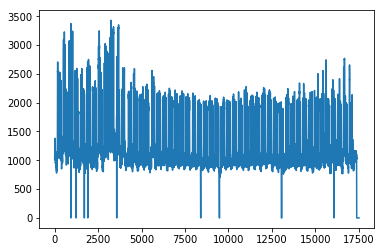

In [6]:
#2016 demand plotline
bms_demand_2016 = add_day_type_column("bms_2016.csv",'?Timestamp')
bms_demand_2016.rename(columns={'?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2016['kVA'].plot.line()


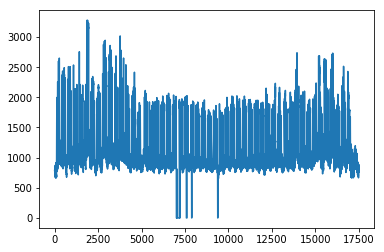

In [7]:
#read data file and add type of day column to it
bms_demand_2017 = add_day_type_column('bms_2017_kva.csv','?Timestamp')
bms_demand_2017.rename(columns={'ML_PH/Main_11kV_kW (kW)': 'kW','?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2017['kVA'].plot.line()

#imputed kva's plot line (replaced from last year values)
#bms_2017_imputed = replace_zeros(bms_demand_2017, bms_demand_2016)
#bms_2017_imputed['kVA'].plot.line()

#Estimate kW using kVA if kW values not recorded
#bms_demand_2017_est = campus_power_estimation(bms_2017_imputed)
#bms_demand_2017_est['kW_est'].plot.line()


In [8]:
#test code
test_2017 = bms_demand_2017
test_2016 = bms_demand_2016
#bms_demand_2017.where(bms_demand_2017['kVA'] != 0 && bms_demand_2017['TimeStamp'].apply(lambda x: datetime.date(x)) 
 #                     , bms_demand_2016['kVA'],axis=0)
#test_2016_without_29 = test_2016.drop(test_2016[(test_2016['TimeStamp'] >= '2016-02-29 00:00:00') & (test_2016['TimeStamp'] < '2016-03-01 00:00:00')].index).reset_index(drop=True)
#test_2017.sort_index(inplace=True)


In [9]:
#test_2016_without_29['TimeStamp'] = test_2016_without_29['TimeStamp'].apply(lambda x: x.replace(year = 2017))
#replace_zeros(test_2017,test_2016_without_29)


In [11]:
bms_demand_2017_est = campus_power_estimation(bms_demand_2017)
bms_demand_2017_est.to_csv("bms_etsimated_2017.csv", sep=',', encoding='utf-8')


In [ ]:
test_2016_without_29

In [12]:
#bms_demand_2017_est['Type_of_day'].unique()
bms_demand_2017_est['Type_of_day'].unique()

array(['Major_study_break', 'Study_period_day', 'Weekend',
       'Public_holiday'], dtype=object)

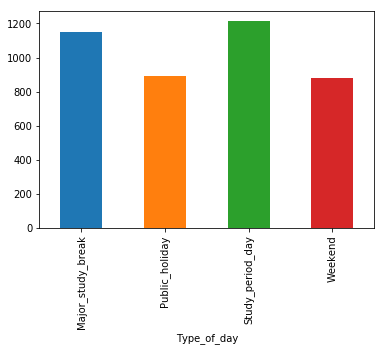

In [13]:
# Distribution of consumption during different day type's
grouped_by_daytype = bms_demand_2017_est.groupby(['Type_of_day'])['kW_est'].mean()
grouped_by_daytype
grouped_by_daytype.plot.bar()

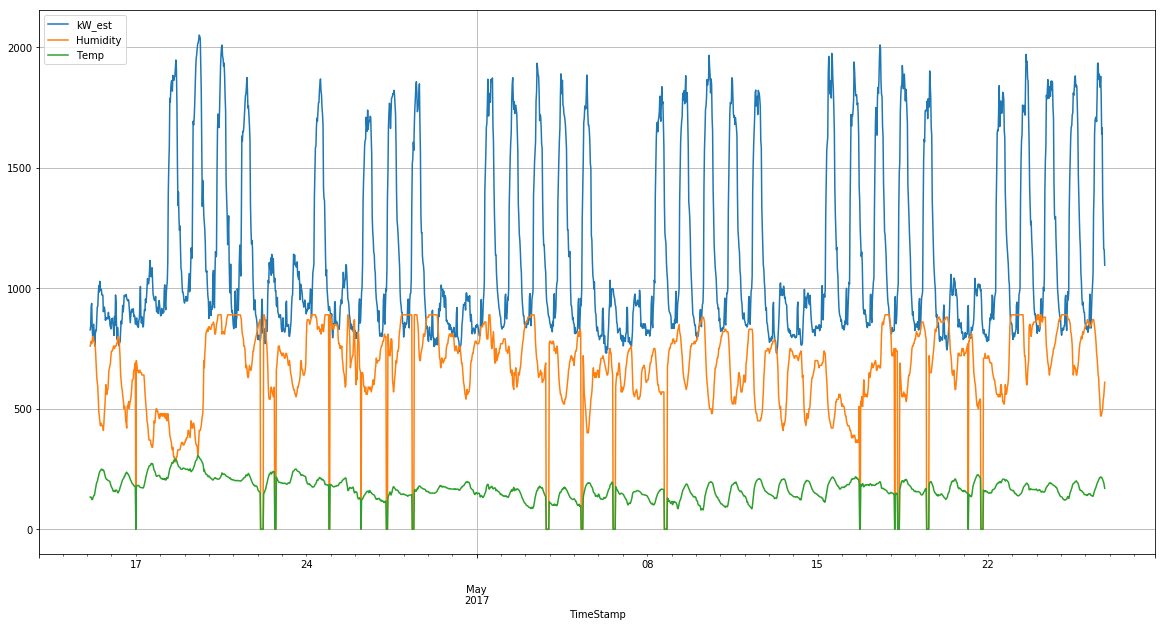

In [14]:
# change scale of humidity and temperature
bms_transformed = bms_demand_2017_est[['TimeStamp','kW_est', 'Type_of_day','Humidity','Temp']].copy()
bms_transformed['Humidity'] = bms_transformed['Humidity'].apply(lambda x: x*10)
bms_transformed['Temp'] = bms_transformed['Temp'].apply(lambda x: x*10)
bms_transformed.loc[5000:7000].plot(x='TimeStamp', y=['kW_est','Humidity','Temp'] ,figsize=(20,10), grid=True  )

               kVA        kW  Humidity      Temp    kW_est
kVA       1.000000  0.619806 -0.310461  0.470977  0.998436
kW        0.619806  1.000000 -0.130496  0.080648  0.659070
Humidity -0.310461 -0.130496  1.000000 -0.606740 -0.299412
Temp      0.470977  0.080648 -0.606740  1.000000  0.446762
kW_est    0.998436  0.659070 -0.299412  0.446762  1.000000


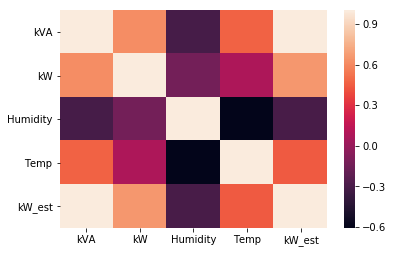

In [15]:
#Check correations among attributes
corr_val = bms_demand_2017_est.corr()
print (corr_val)
import seaborn as sns
sns.heatmap(corr_val, 
        xticklabels=corr_val.columns,
        yticklabels=corr_val.columns)

In [16]:
#interctive graphs - work in progress
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

In [ ]:
pv = pd.pivot_table(bms_kw_est, index=['Name'], columns=["Status"], values=['Quantity'], aggfunc=sum, fill_value=0)

In [ ]:
trace1 = go.Bar(x=bms_kw_est.TimeStamp, y=bms_kw_est[('Quantity', 'declined')], name='Declined')
trace2 = go.Bar(x=pv.index, y=pv[('Quantity', 'pending')], name='Pending')
trace3 = go.Bar(x=pv.index, y=pv[('Quantity', 'presented')], name='Presented')
trace4 = go.Bar(x=pv.index, y=pv[('Quantity', 'won')], name='Won')

                              ARMA Model Results                              
Dep. Variable:                 kW_est   No. Observations:                17520
Model:                     ARMA(3, 0)   Log Likelihood             -102432.334
Method:                       css-mle   S.D. of innovations             83.727
Date:                Mon, 08 Oct 2018   AIC                         204874.668
Time:                        11:52:05   BIC                         204913.524
Sample:                             0   HQIC                        204887.463
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1158.0877     21.767     53.205      0.000    1115.426    1200.750
ar.L1.kW_est     1.3039      0.008    173.036      0.000       1.289       1.319
ar.L2.kW_est    -0.2622      0.012    -21.41

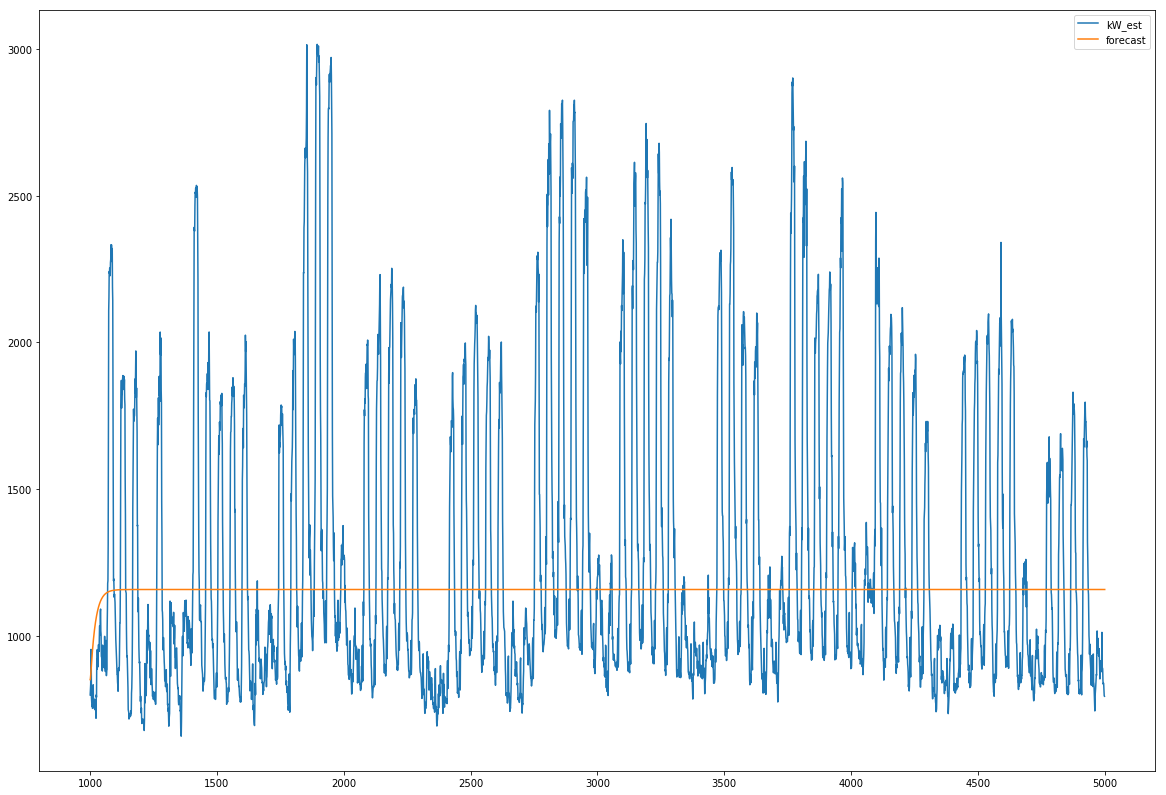

In [17]:
#arma model
import statsmodels.api as sm
demand = bms_demand_2017_est['kW_est']

res = sm.tsa.ARMA(demand, (3, 0)).fit(disp=0)
print(res.summary())
fig, ax = plt.subplots(figsize = (20,14))
ax = demand[1000:5000].plot(ax=ax)
res.plot_predict(1000, 5000, dynamic=True, ax=ax,plot_insample=False)

plt.show()


In [ ]:
demand[17499:17600]

In [18]:
#demand_log = np.log(demand)

res = sm.tsa.ARMA(demand_log, (3, 0)).fit(disp=0)
print(res.summary())
fig, ax = plt.subplots(figsize = (20,14))
ax = demand_log[1000:5000].plot(ax=ax)
res.plot_predict(1000, 5000, dynamic=True, ax=ax,plot_insample=False)

plt.show()

C:\Users\MeAmit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log

C:\Users\MeAmit\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:492: RuntimeWarning:

invalid value encountered in subtract



LinAlgError: Array must not contain infs or NaNs

In [25]:
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults


In [ ]:
demand = bms_demand_2017_est['kW_est']

plt.plot(demand)
plt.show()
acf_1 =  acf(demand)[1:20]
plt.plot(acf_1)
plt.show()
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Pandas Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 =  pacf(demand)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
result = ts.adfuller(demand, 1)
result

C:\Users\MeAmit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                17519
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -102336.708
Method:                       css-mle   S.D. of innovations             83.306
Date:                Mon, 08 Oct 2018   AIC                         204689.417
Time:                        13:53:08   BIC                         204751.585
Sample:                             1   HQIC                        204709.887
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      1.341      0.003      0.997      -2.623       2.632
ar.L1.D.y      0.7977      0.052     15.391      0.000       0.696       0.899
ar.L2.D.y     -0.4040      0.089     -4.556      0.0

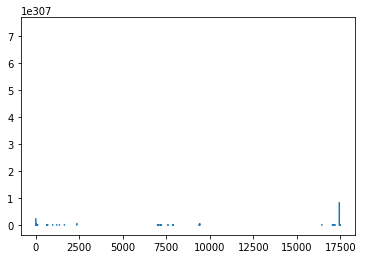

In [70]:
demand_matrix=demand.as_matrix()
model = ARIMA(demand_matrix, order=(3,1,3))
model_fit = model.fit(disp=0)
fits = model_fit.fittedvalues
residuals = model_fit.resid
print(model_fit.summary())
predictions = model_fit.predict(2,17600, typ = 'levels')
predictions
predictionsadjusted = np.exp(predictions)
plt.plot(predictionsadjusted)
plt.show()

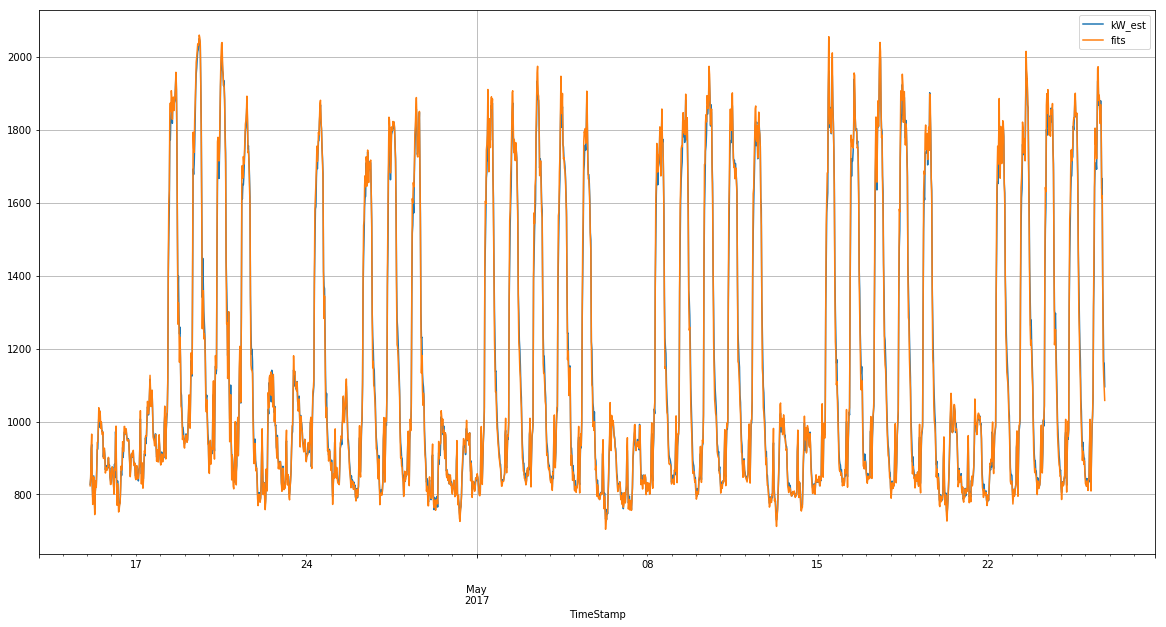

In [71]:
#results = ARMAResults(model,predictions)
#fittedValues = results.fittedvalues
#append 0 in first element
fits = np.concatenate([[0],fits])
bms_demand_2017_est['fits'] = bms_demand_2017_est['kW_est'] + fits
bms_demand_2017_est.loc[5000:7000].plot(x='TimeStamp', y=['kW_est','fits'] ,figsize=(20,10), grid=True  )

In [65]:
x = 0

17520


array([ 0.00000000e+00,  4.29211492e-03,  3.68777760e+00, ...,
        6.07516590e+00, -2.22305129e+00, -3.21841507e+00])

NameError: name 'dta' is not defined

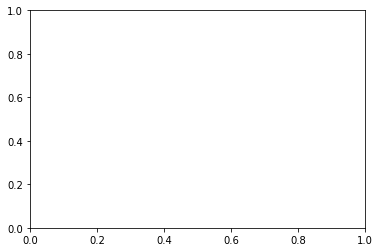

In [55]:
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
res.plot_predict('1990', '2012', dynamic=True, ax=ax,
                 plot_insample=False)

In [ ]:
model_fit